Preliminary Data analysis

avg 26.32895970009372
22.0
31.0


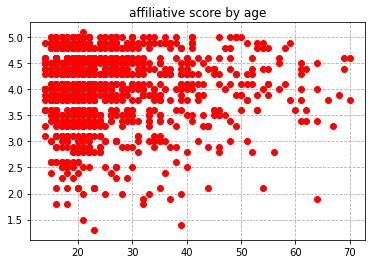

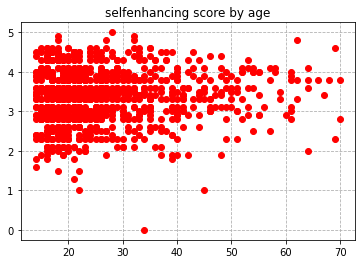

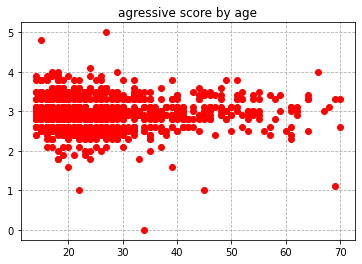

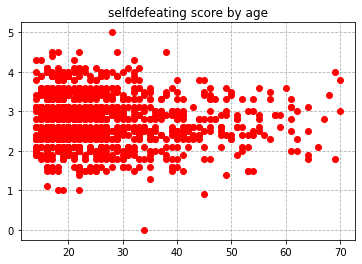

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

with open('data.csv', newline='') as file:
    reader = csv.reader(file, delimiter=',')
    keys = next(reader)
    data = np.loadtxt(file, delimiter=',')

def gender_box_plot(set_index, set_name):
    split_sets = [[], [], []]
    genders = ['male', 'female', 'other']

    for i in data:
        gender = int(i[37])
        if gender > 0 and gender <= 3:
            if set_index == 36:
                if i[set_index] < 150:
                    split_sets[gender-1].append(i[set_index])
            else:
                split_sets[gender-1].append(i[set_index])
    fig, ax = plt.subplots()
    ax.set_title(set_name)
    ax.set_xticklabels(genders)
    ax.grid(axis='y', linestyle = '--')
    ax.boxplot(split_sets, showmeans=True,whis=4)
    plt.show()

def by_age(set_index, set_name):
    fig, ax = plt.subplots()
    ax.set_title(set_name)
    filtered_data = [[],[]]
    for i in data:
        age = i[36]
        if age < 150:
            filtered_data[0].append(age)
            filtered_data[1].append(i[set_index])
    ax.grid(axis='y', linestyle = '--')
    ax.grid(axis='x', linestyle = '--')
    ax.plot(filtered_data[0], filtered_data[1], 'ro')
    plt.show()

def age_bplot():
    fdata = []
    for i in data:
        age = i[36]
        if age < 124:
            fdata.append(age)
    fig, ax = plt.subplots()
    ax.set_title('Age Boxplot')
    ax.boxplot(fdata, showmeans=True, whis=3)
    ax.grid(axis='y', linestyle = '--')
    plt.show()

count = 0
total = 0
valid_ages = []
for i in data:
    age = i[36]
    if age < 124:
        total += age
        count += 1
        valid_ages.append(age)
print(f'avg {total/count}')
print(np.median(valid_ages))
print(np.quantile(valid_ages, 0.75))

for i in range(32, 36):
    by_age(i, f'{keys[i]} score by age')

Data input and cleaning

In [2]:
invalid_ages = []
print(data.shape)
for i in range(data.shape[0]):
    if data[i, 37] == 0:
        data[i, 37] = 3
    if data[i, 36] > 124:
        invalid_ages.append(i)
clean_data = np.delete(data, invalid_ages, axis=0)

#drop the 4 hsq scores (affiliativeness, self-enhancing etc) to avoid multicollinearity as these are directly dependent on the 32 questions
clean_data = np.delete(clean_data, [32, 33, 34, 35], axis=1)
print(clean_data.shape)

(1071, 39)
(1067, 35)


Feature Scaling, data splitting and imputing

In [3]:
#standardisation
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


y = clean_data[:,32] #age column
X = np.delete(clean_data, 32, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

questions = list(range(32))
numericals = list(range(32))
numericals.append(33)

imputer = SimpleImputer(missing_values=-1, strategy='mean')
col_imputer = ColumnTransformer(remainder='passthrough', transformers=[
    ('imp', imputer, questions)
])
col_transformer = ColumnTransformer(remainder="drop", transformers=[
    ('std', StandardScaler(), numericals),
    ('oh', OneHotEncoder(), [32])
])


Output scaling, Training, Hyperparameter tuning, and evaluation

[-0.02677232 -0.00696277 -0.12241321 -0.06615072  0.04546492 -0.00096571
  0.02349389  0.01902821 -0.05205006 -0.01822632 -0.00969617  0.11251784
 -0.06878376  0.01981631  0.12929281 -0.10147637 -0.00468002  0.02102149
 -0.03337181 -0.01272212  0.04012819 -0.00095607  0.02556987 -0.10529643
  0.08643631  0.14174593  0.03237939 -0.0751369   0.02708714 -0.02930057
  0.00605897 -0.01562808  0.04209094  0.047093   -0.04134362 -0.00574938]
Chosen alpha: 100.0 MSE score: -0.898802261629898
R2 Score on test set: 0.12155127757128603, MSE score on test set: 96.7430690493613, RMSE score: 9.835805460121774
[-0.00993043 -0.         -0.12782858 -0.05404199  0.03422571 -0.
  0.01586461  0.         -0.03871344 -0.         -0.          0.11126917
 -0.05268993  0.          0.13116158 -0.09013921 -0.          0.
 -0.02128498 -0.          0.02600437  0.          0.00675977 -0.10506742
  0.07991742  0.14681758  0.00646067 -0.06694815  0.         -0.01500167
  0.00058409 -0.          0.03015201  0.03406023

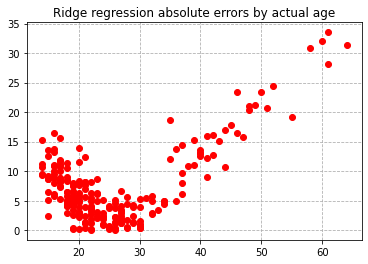

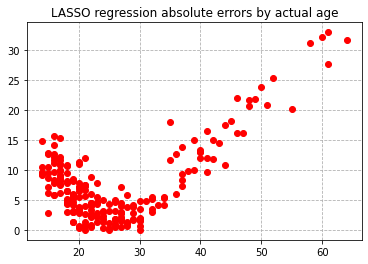

In [4]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

bin_ages_encoder = KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'quantile') #used for kNN
ytest = y.reshape(-1, 1)
y2 = bin_ages_encoder.fit_transform(ytest).transpose()[0]
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=0, stratify=y2) # X2_test (and train) equal to X_test

#output scaling for regression 
ridge = RidgeCV(alphas = np.logspace(-5, 5, 11), store_cv_values=True) #Uses efficient leave one out cross validation, and scoring by MSE
LASSO = LassoCV(max_iter=1000000, n_jobs=12) #I ran this on a 12 thread cpu, change this value if the machine this runs on has fewer than 12 threads (and later instances of n_jobs)

rr = TransformedTargetRegressor(regressor = ridge, transformer=StandardScaler())
lr = TransformedTargetRegressor(regressor=LASSO, transformer = StandardScaler())

kNN = KNeighborsClassifier(n_jobs=12)
param_grid = {'n_neighbors': np.arange(10, 510, 20)}
kNN_GSCV = GridSearchCV(kNN, param_grid, n_jobs=12, scoring='accuracy') #as bins are created by quantiles accuracy shouldnt cause any problems


rr_pipe = Pipeline([('imp', col_imputer), ('trans', col_transformer), ('ridge', rr)])
lr_pipe = Pipeline([('imp', col_imputer), ('trans', col_transformer), ('lasso', lr)])
kNN_pipe = Pipeline([('imp', col_imputer), ('trans', col_transformer), ('kNN', kNN_GSCV)])

rr_model = rr_pipe.fit(X_train, y_train)
rr_alpha = rr_model['ridge'].regressor_.alpha_
rr_score = rr_model['ridge'].regressor_.best_score_
rr_coefs = rr_model['ridge'].regressor_.coef_
print(rr_coefs)
print(f'Chosen alpha: {rr_alpha} MSE score: {rr_score}')

rr_final_score = rr_model.score(X_test, y_test)
rr_y_pred = rr_model.predict(X_test)
mse = mean_squared_error(y_test, rr_y_pred)
print(f'R2 Score on test set: {rr_final_score}, MSE score on test set: {mse}, RMSE score: {mse**0.5}')

lr_model = lr_pipe.fit(X_train, y_train)
lr_coefs = lr_model['lasso'].regressor_.coef_
print(lr_coefs)
lr_alpha = lr_model['lasso'].regressor_.alpha_
print(f'Chosen alpha: {lr_alpha}')

lr_final_score = lr_model.score(X_test, y_test)
lr_y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, lr_y_pred)
print(f'R2 Score on test set: {lr_final_score}, MSE score on test set: {mse}, RMSE score: {mse**0.5}')

kNN_model = kNN_pipe.fit(X2_train, y2_train)
final_k = kNN_model['kNN'].best_params_['n_neighbors']
best_score = kNN_model['kNN'].best_score_
print(f'Best k: {final_k}, Best score: {best_score}')

kNN_final_score = kNN_model.score(X2_test, y2_test)
print(f'Score on test set (accuracy): {kNN_final_score}')


rr_errors = []
lr_errors = []
for i in range(len(y_test)):
    rr_errors.append(((rr_y_pred[i]-y_test[i])**2)**0.5)
    lr_errors.append(((lr_y_pred[i]-y_test[i])**2)**0.5)

def by_test_age(regr, title):
    fig, ax = plt.subplots()
    ax.set_title(f'{title} absolute errors by actual age')
    ax.grid(axis='y', linestyle = '--')
    ax.grid(axis='x', linestyle = '--')
    ax.plot(y_test, regr, 'ro')
    plt.show()

by_test_age(rr_errors, 'Ridge regression')
by_test_age(lr_errors, 'LASSO regression')
